# Abstract

**Premise:** In this analysis we restricted ourselves to the study of aquifers (so you don't find any reference
lo lakes, watersprings and rivers).

We used principally the Auser data for creating our model and let the other aquifers
as a test.

**INTRODUCTION*!*:

The aim of this work is to create a model for predicting the water level in an aquifer in *d* days using
several data collected in the last *k* days and a rainfall forecasting for the next *d* days.

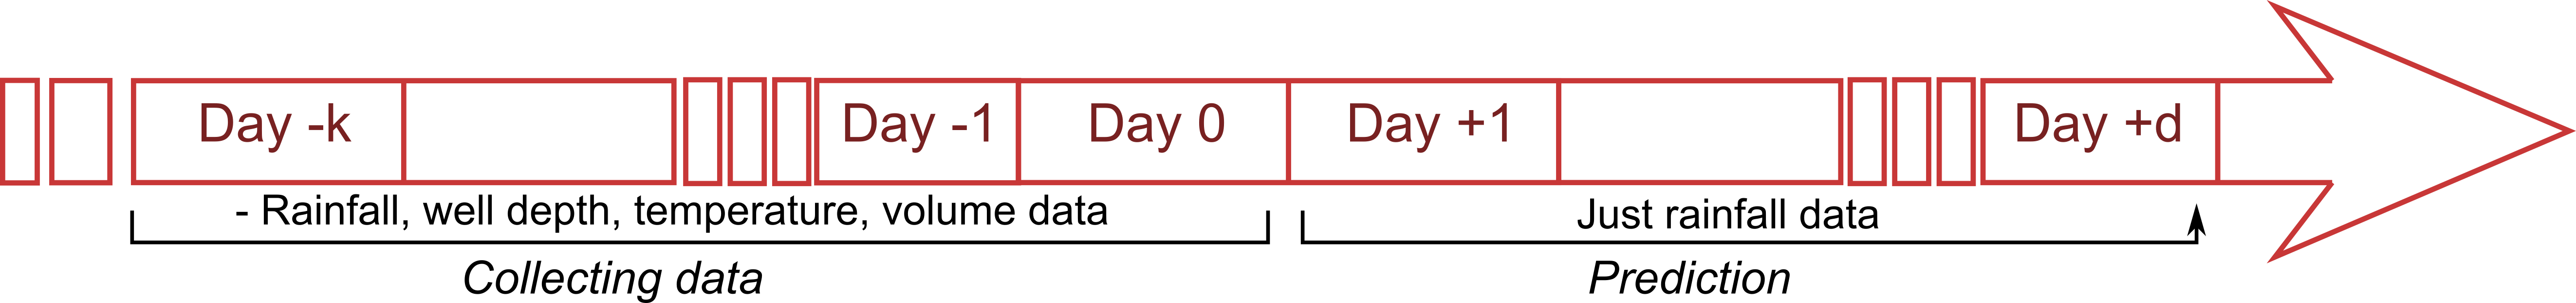

N.B. Data of the last *k* days includes *k+1* values and not *k* (*k=0* is the "zero day")

Remark that to establish optimal values for *k* and *d* is a part of the issue. Futhermore the best value
of *k* could diverge for different predictors.
In this work we choose *d*=10 and k=0 for all the predictors excepted rainfall, where we choose k=2.


**Aims**:
- Developing a working model for predicting well depth;
- Identify the dependency of the well depth by the predictors. This request more challenging than it sounds,
especially concerning temperature. Indeed we need to split the dependencies of well depth by temperature
into the seasonal components, the relation between temperature and rainfall and the effect on soil absorption

**1. DATA PREPROCESSING**

**1.1 Missing data**

For the aquifer Auser missing data are not too much, so we proceeded as following:
- Replaced missing values in a location by prediction based on other locations for rainfall and temperature;
- Dropped one location for temperature since unavailable measures were too much;
- Dropped days with missing values in depth of analysed well.

**1.2 Exploratory Data Analysis**
(carried on Auser aquifer)
- We decided to ignore the hydrometry data, since too noised and too unlike between different years;
- We chose *d=10* for time prediction and *k=2* for rainfall data
- Rainfall seems to be the most important predictor.
- Rainfall importance in prediction by day seems to follow two patterns, probably depending on well properties.


**2 GROUPED LASSO**

**2.1 Generalities**

As our data are essentially a time series, we have two options for train-test split ,
random and time-based split, with different pros and cons:
RANDOM SPLIT:
    PROS:
    - Different possibilities for subsampling, based on random seed (more reliable results);
    CONS:
    - Possible data leakage;
    - Does not reflect the real application;
    - We could not trace the time dependency without leakage.

TIME-BASED SPLITTING:
    PROS:
    - No data leakage, even with a time dependency feature;
    - More similar to the real application
    CONS:
    - Not many ways for splitting data (less reliable results)


We take R^2 as metric for predictions

**2.2 Feature selection/Data augmentation**

All features are firstly normalized and we used a spline for coding non-rainfall features
The selection of more significant features is automatically performed by LASSO algorithm during the data fitting
Some time-based features are added, expressing the seasonal and the time factor.

**2.3 Implementation**

Group regularisation is tuned by a 5-folds time-series-split cross validation. We keep l1 regularisation
We analyse different features combination, evaluating the model performance on all wells for each.

**3 DISCUSSION AND RESULTS**

**3.1 Application to other aquifers**

The methods developped for Auser are applied on the other aquifers.

**3.2 Conclusions and remarks**

Some conclusion about the model results



In [ ]:
#Importing required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, date #for deal with dates
import matplotlib.pyplot as plt #plot data
import seaborn as sns #plot data
from patsy import dmatrices, dmatrix #preprocessing
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV #Cross validation over time series
!pip install group-lasso
from group_lasso import GroupLasso #Grouped lasso model
from tqdm import tqdm #progress bar

In [ ]:
# Some function for loading the aquifer and visualize data:

# LOADING DATA
def load_data(name):
    df = pd.read_csv(f"../input/acea-water-prediction/Aquifer_{name}.csv")
    # Read date in european format
    df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
    return df

#IDENTIFY COLUMNS CONTAINING A KEY WORD
def extract_col(df, substr):
    return [col for col in df.columns if substr in col]

# PLOT MISSING VALUES
def show_missing(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    fig.suptitle(f'Missing values in {aquifer_name}', fontsize=20)
    #Set all the labels on y axis with yticklabels=True
    sns.heatmap(df.T.isna(), cmap='Greys')
    ax.set_xlabel("Dates", fontsize=14)
    ax.set_ylabel("Columns", fontsize=14)
    #Extracting x-labels as numbers
    x_labels = [int(tick.get_text()) for tick in ax.get_xticklabels()]
    #Converting indexes to dates
    new_labels = df["Date"].iloc[x_labels]
    new_labels = new_labels.astype('string') #as strinf for best formatting
    #Setting the new labels
    ax.set_xticklabels(new_labels)
    #Setting font size for y labels
    for i in ax.yaxis.get_major_ticks():
        i.label.set_fontsize(12)
    #Adding horizontal and vertical lines (very customizable)
    ax.hlines(range(1,df.shape[1]),0,df.shape[0], linewidth=0.2, colors='gray')
    ax.vlines(range(1,df.shape[0],365),0,df.shape[1], linewidth=0.1, colors='gray')


# PLOTTING ALL DATA
def plot_all(aquifer):
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(30,15))
    fig.suptitle(f'Comparing {aquifer_name} data', fontsize=20)
    #Expliciting the number plot of each column in data
    class_columns = ["Rainfall", "Depth_to_Groundwater", "Volume", "Temperature", "Hydrometry"]
    for i in range(1,aquifer.shape[1]):
        for c, classe in enumerate(class_columns):
            if classe in aquifer.columns[i]:
                ax[c].plot(aquifer.Date,aquifer.iloc[:,i], label=aquifer.columns[i])
    for j in range(0,5):
        #The upper left corner of the legend is in position 0.98, 1
        ax[j].legend(bbox_to_anchor=(0.98, 1), loc='upper left')

We start our analysis from Auser aquifer, plotting all data and visualizing the missing ones.

In [ ]:
aquifer_name = "Auser"
aquifer = load_data(aquifer_name)
show_missing(aquifer)
plot_all(aquifer)

Looking at graphs we remark that many missing values are masked by zeros, in temperature, depth well and volume.
So we can replace them by NaN.

Furthermore, until 2006 we do not have any interesting data, so we can simply drop them

In [ ]:
#Drop data before 2006
def drop_by_column(old_aquifer, col):
    aquifer = old_aquifer.copy()
    begin_date = aquifer[aquifer.iloc[:,col].notna()].iloc[0,0]
    aquifer = aquifer[aquifer["Date"] >= begin_date]
    aquifer = aquifer.reset_index(drop=True)
    return aquifer

#replace zeros by NaN
def replace_with_nan (aquifer):
    for col in extract_col(aquifer,"Temperature"):
        aquifer[col] = aquifer[col].replace([0],float('nan'))
    for col in extract_col(aquifer,"Volume"):
        aquifer[col] = aquifer[col].replace([0],float('nan'))
    for col in extract_col(aquifer,"Depth"):
        aquifer[col] = aquifer[col].replace([0],float('nan'))
    return aquifer
aquifer = drop_by_column(aquifer, 1)
aquifer = replace_with_nan(aquifer)

show_missing(aquifer)

So these are the actual missing values. More in details:

In [ ]:
# We check missing values
def print_missing(aquifer):
    for col in aquifer.columns:
        print("NaN values in %s = %2.0f corresponding to  %2.5f%% "
              % (col, aquifer[col].isnull().sum(), 100*aquifer[col].isnull().sum()/aquifer.shape[0]))
print_missing(aquifer)

For columns with very few missing values (less than 10) we can just replace them by median.
For Temperature_Ponte_a_Moriano column, we can just drop it (we have already two column temperature
so it's not a big deal).
For other columns with not too much missing values (less than 10%) we replace them by a prediction.
based on other columns.
We replace Volume by median.
For Hydrometry and Depth Well, we can not replace them, so we will drop at the very last moment,
when we will fit our model.

In [ ]:
def replace_volume(aquifer):
    vol_features = extract_col(aquifer, "Volume_")
    for col in vol_features:
        aquifer[col] = aquifer[col].fillna(aquifer[col].median())
    return aquifer

def replace_little_missing(aquifer):
    for col in aquifer.columns[1:]: #skip date column
        if aquifer[col].isnull().sum()<10:
           aquifer[col] = aquifer[col].fillna(aquifer[col].median())
    return aquifer

del aquifer["Temperature_Ponte_a_Moriano"] #we are not going to use this data
aquifer = replace_little_missing(aquifer)
aquifer = replace_volume(aquifer)


We fit a model for replacing missing rainfalls:

In [ ]:
#Fill values on a column using data in the same class
def fill_by_correlation(aquifer, class_name, index):
    #columns of specified class
    features = extract_col(aquifer, class_name)
    target = features[index]
    #drop NaN
    reduced_aquifer = aquifer[features].dropna()
    features.remove(target)
    x = reduced_aquifer[features]
    y = reduced_aquifer[target]
    #fit a Lasso model with Gridsearch for hyperparameter tuning
    from sklearn.linear_model import Lasso
    model = Lasso(fit_intercept=False)
    parameters = { 'alpha':[0.01, 0.025, 0.05, 0.1, 0.25, 0.5,  1, 2.5]}
    clf = GridSearchCV(model, parameters)
    clf.fit(x, y)
    reg = clf.best_estimator_.fit(x, y)
    #now get all values, NaN included
    all_x = aquifer[features]
    y_pred = reg.predict(all_x)
    #get index for missing values in Rainfall_Piaggione
    missing_data = aquifer[aquifer[target].isna()].index
    #replace the missing data by their prediction (using loc to avoid SettingWithCopyWarning)
    aquifer.loc[missing_data, target] = y_pred[missing_data]
    return aquifer

aquifer = fill_by_correlation(aquifer, "Rainfall_", 5)
aquifer = fill_by_correlation(aquifer, "Temperature_", 1)

## 1.2 Exploratory Data Analysis

### 1.2.1 Choice for *d* and *k* ###
We start looking for the optimal value of *d*

The target variable will be "delta_depth" i.e. the difference in depth_level between day *d* and day *0*.
This variable is more reliable and suitable for prediction and eliminate some (but not all) correlation with
the old well depth.

We perform a linear regression (enough precise and faster than others models) for predicting
the well depth using the rainfall data and a season information (day of the year) coded by a
cyclic spline (since the dependency by season is not linear and it is clearly cyclic).

We test values of *d* from 1 to 100, and values of *k* from 0 to 7

In [ ]:
#Some functions we are going to use for formatting data

#add some columns about old rain data depending on max_day_before
def add_mean_rain(old_aquifer,max_day_before):
    aquifer = old_aquifer.copy()
    #Calculating mean rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    aquifer[rain_name] = aquifer[rain_name].fillna(0)
    aquifer["mean_rain"] = aquifer[rain_name].mean(axis=1)
    #Add columns for old rain
    for d in range(max_day_before):
        aquifer["mean_rain_"+str(d)] = aquifer["mean_rain"].shift(d)
    return aquifer

#add some columns about wel depth depending on max_day_before
def format_wells(old_aquifer, max_day_before):
    aquifer = old_aquifer.copy()
    wells_name = extract_col(old_aquifer, 'Depth_to_')

    for col in wells_name:
        aquifer[col+"_old_"+str(max_day_before)] = aquifer[col].shift(max_day_before)
        aquifer[col+"_delta_"+str(max_day_before)] = aquifer[col] - aquifer[col+"_old_"+str(max_day_before)]
    return aquifer

#add a column for the seasonality
def add_day_of_year(old_aquifer):
    aquifer = old_aquifer.copy()
    aquifer["day_year"] = aquifer["Date"].dt.dayofyear
    return aquifer

In [ ]:

def plot_d_k_prediction(max_d, max_k, aquifer):
    time_interval = list(range(1,max_d)) #we test predictions between 1 and 100 days
    well_list = extract_col(aquifer, "Depth")  #list of all well depth columns
    for k in range(max_k):
        print(f"Making prediction for k={k}...")
        r2_scores = {well_name:[] for well_name in well_list}
        for d in tqdm(time_interval):
            aquifer_d_days = add_mean_rain(aquifer, d + k) #add old rainfall
            aquifer_d_days = format_wells(aquifer_d_days, d) #add old well depth
            aquifer_d_days = add_day_of_year(aquifer_d_days) #add season feature
            for well_target in well_list:
                target = well_target +"_delta_"+str(d)

                features_rain = extract_col(aquifer_d_days, 'mean_rain_')
                features_season = extract_col(aquifer_d_days, 'day_year')
                features = features_rain + features_season
                all_columns = features + [target]

                aquifer_d_days_data = aquifer_d_days[all_columns].dropna()
                aquifer_d_days_data = aquifer_d_days_data.reset_index(drop=True)
                # Now we need to separate data in train and test (we use a shuffle for sake of simplicity)
                train = aquifer_d_days_data.sample(frac=0.8,random_state=22) #random state is a seed value
                test = aquifer_d_days_data.drop(train.index)
                #we use a cyclic spline for formatting the season feature
                formula = f"{target} ~ cc(day_year, df=6) + " + "+ ".join(features_rain)

                y_train, x_train = dmatrices(formula, train, return_type='dataframe')
                y_test, x_test = dmatrices(formula, test, return_type='dataframe')
                #We try predict the difference in depth level using just a linear regression
                from sklearn.linear_model import LinearRegression
                model = LinearRegression()
                reg = model.fit(x_train, y_train)
                r2_scores[well_target].append(reg.score(x_test, y_test))
        #Plot the graph for all R^2 scores
        fig, ax = plt.subplots()
        for well_name in well_list:
            ax.scatter(time_interval, r2_scores[well_name], s=4, label=well_name)
            ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
            ax.set(title=f'R^2 depending by time interval for k={k}', ylabel='R^2', xlabel='Prediction days')

# This can take some time..
plot_d_k_prediction(100,9,aquifer)

We remark the following:

- Greater values of *k* increase not much the reliability of the prediction. SO we decide to keep *k=2*
- Increasing *d* improve the prediction. We could suggest three reasons:
        - in a longer lapse of time noise effects are reduced compared to deterministic phenomena;
        - water has more time to be absorbed by the soil;
        - the seasonality achieve more importance than the effect of rain.

The last point is highlighted by the graph produced by the following code.
We do a prediction for 0<d<100 using, for all cases, only the last ten days of rainfall.
Despite the apparent lack of data, the prediction perform pretty well on long lapses of time, since
the seasonality component overwhelmes the rainfall feature.

In [ ]:
well_list = extract_col(aquifer, "Depth")
d_rain = 10
r2_scores = {well_name:[] for well_name in well_list}
time_interval = list(range(1,100))
k=2
for d in tqdm(time_interval):
    aquifer_d_days = add_mean_rain(aquifer, d_rain + k) #add old rainfall
    aquifer_d_days = format_wells(aquifer_d_days, d) #add old well depth
    aquifer_d_days = add_day_of_year(aquifer_d_days) #add season feature
    for well_target in well_list:
        target = well_target +"_delta_"+str(d)

        features_rain = extract_col(aquifer_d_days, 'mean_rain_')
        features_season = extract_col(aquifer_d_days, 'day_year')
        features = features_rain + features_season
        all_columns = features + [target]

        aquifer_d_days_data = aquifer_d_days[all_columns].dropna()
        aquifer_d_days_data = aquifer_d_days_data.reset_index(drop=True)
        # Now we need to separate data in train and test (we use a shuffle for sake of simplicity)
        train = aquifer_d_days_data.sample(frac=0.8,random_state=22) #random state is a seed value
        test = aquifer_d_days_data.drop(train.index)
        #we use a cyclic spline for formatting the season feature
        formula = f"{target} ~ cc(day_year, df=6) + " + "+ ".join(features_rain)

        y_train, x_train = dmatrices(formula, train, return_type='dataframe')
        y_test, x_test = dmatrices(formula, test, return_type='dataframe')
        #We try predict the difference in depth level using just a linear regression
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        reg = model.fit(x_train, y_train)
        r2_scores[well_target].append(reg.score(x_test, y_test))
#Plot the graph for all R^2 scores
fig, ax = plt.subplots()
for well_name in well_list:
    ax.scatter(time_interval, r2_scores[well_name], s=4, label=well_name)
    ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
    ax.set(title=f'R^2 depending by time interval for k={k}', ylabel='R^2', xlabel='Prediction days')

So the R^2 score increase for the first ten days for all wells (where rain data are avaible).
Then it decreases for some time  and increase again after about 20-40 days, when the seasonality
can balance the missing data for rainfalls.

It is our conviction that a prediction based on merely season patterns is less interesting
and with less applications than one based on collected data as rainfall.

So we find it is a good compromise the choice *d=10*, since it represents a time interval:
- long enough to achieve good predictions;
- short enough to overlook season patterns;
- optimal for using reliable weather forecasting on rainfall features.

### 1.2.2 Rainfall importance by day###

The following code plot the importance (i.e. coefficient value) that each rainfall
day in the prediction. Each graph is obtained from a prediction by *d* days, *with 0<d<31*.
Each color is associated to a different well.

We remark that the behavior is different for different wells. We could identify two patterns:

- CoS, SAL:  All days share about the same importance, but last days are less important
(maybe water has not been yet absorbed?)

- LT2, PAG: Day importance is decreasing with time (maybe water is absorbed more quickly
and the well discharge on other aquifers?)

DIEC behavior is halfway theese two classes.

In [ ]:
max_d = 31
k = 4
time_interval = list(range(1,max_d)) #we test predictions between 1 and 100 days
well_list = extract_col(aquifer, "Depth")  #list of all well depth columns
fig, axs = plt.subplots(nrows=max_d//3,ncols=3,figsize=(20,max_d*1.4))
num_ax = 0
bar_width = 0.8/len(well_list)
for d in tqdm(time_interval):
    aquifer_d_days = add_mean_rain(aquifer, d + k) #add old rainfall
    aquifer_d_days = format_wells(aquifer_d_days, d) #add old well depth
    aquifer_d_days = add_day_of_year(aquifer_d_days) #add season feature

    for i, well_target in enumerate(well_list):
        target = well_target +"_delta_"+str(d)

        features_rain = extract_col(aquifer_d_days, 'mean_rain_')
        features_season = extract_col(aquifer_d_days, 'day_year')
        features = features_rain + features_season
        all_columns = features + [target]

        aquifer_d_days_data = aquifer_d_days[all_columns].dropna()
        aquifer_d_days_data = aquifer_d_days_data.reset_index(drop=True)
            #we use a cyclic spline for formatting the season feature
        formula = f"standardize({target}) ~ cc(day_year, df=6) + " + "+ ".join(features_rain)

        y, x = dmatrices(formula, aquifer_d_days_data, return_type='dataframe')

        #We try predict the difference in depth level using just a linear regression
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
        reg = model.fit(x, y)

        rain_index = [list(x.columns).index(item) for item in features_rain]
        day_scores = np.abs(reg.coef_[0][rain_index])

        axs[num_ax//3,num_ax%3].bar(np.arange(1,d+1+k)+i*bar_width, day_scores, width= bar_width, label=well_target)
        axs[num_ax//3,num_ax%3].set_title("Day coefficients for forecast on %d days"%d)
        axs[num_ax//3,num_ax%3].set_xlabel("Days")

    num_ax+=1
axs[0][0].legend(bbox_to_anchor=(1, 1), loc='upper right')


plt.show()

# 2 GROUPED LASSO#

## 2.1 Generalities##
Linear regression performed pretty well during the exploratory data analysis. That is not unexpected,
since essentially the aquifer collects the rains fallen, with some variations caused by the connection with other
aquifers, evaporation etc.

So it is reasonable to model the well depth by a linear combination of rainfall plus the effect (non-linear) of
others features.

However vanilla linear regression could produce overfitting, especially if we decide to study others features
than simlpy rainfall. So, in order to reduce it, we will use **a L1 penalty (LASSO)**.

Since our data are grouped by location, we will use a **grouped LASSO**, which take in account for an additional penalty
related to all the groups. The purpose is to find the location with more influence over the prediction.

We have also another type of group in our dataset, since the **other features are coded by a spline**, we will
include in the same group all the splines coding for the same feature.

Concerning the train-test splitting, we decided to **use a time-based split**. In this way we will get a
framework more similar to a pratical application of the model.

##2.2 Feature selection/Data augmentation##

We list below the operations performed on each feature. All features are firstly normalized.

- **Rainfall**:
    - Rainfall is normalized without subtracting the mean, for keep information about non-raining days.
    - We have d+k (i.e. 12) columns for each location, expressing the rainfall for different days. Data associated to
    the same location belong to the same LASSO group.
    - The selection of the more significant locations is automatically performed by LASSO algorithm during the data fitting

- **Day of the year**
    - This feature introduce the seasonality. It is coded by a cyclic cubic spline, with 6 degrees of freedom
    - It is not penalised by LASSO, to prevent the model using correlation between temperature and season for prediction.

- **Old well depth**
    - Coded by a natural spline with 6 degrees of freedom. Useful for taking in account the shape of the aquifer,
    and all phenomenas associated to water level in the well (for example when aquifer is too filled
    it discharge on other aquifer or river).

- **Temperature**
    - We use the mean temperature of the last *d* days and of all locations.
    - We code it by a natural spline with 6 degrees of freedom.

- **Days from beginning**
    - Not to be confused with "day of the year", it expresses the days from the beginning of the dataset. The aim
    of this feature is taking in account for modification in the hydrology of the aquifer during the years;
    - Since we use a time based train-test splitting, this feature could not be correctly fitted for the test. So
    we replace its value by the last one of the train set for all the test set. So we presume that the aquifer morphology keep
    constant during the test set period of time.
    - Coded by a natural spline with 6 degrees of freedom.


- **Volume**
    - Coded by a unique value normalized


**2.3 Implementation**

Lasso algorithm need some hyperparameters, especially the group and the l1 regularisation. We keep l1 regularisation
very low (0.001) and we tune the group regularisation by a time-series-split cross validation.

We analyse different features combination, evaluating the model performance on all wells for each.

- **min_feat** = Rainfall, Day of year, Well depth;
- **all_feat** = All the features;
- **withtemp_feat** = Rainfall, Day of year, Well depth and temperature.

The following is the code used for the model:

In [ ]:
def format_aquifer(aquifer_old,days, k):
    aquifer = aquifer_old.copy()
    #Calculating total rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    #aquifer["tot_rain"] = aquifer[rain_name].sum(axis=1)

    max_day_before = days #select how long keep old rain record
    for d in range(1, max_day_before + k):
        for col in rain_name:
            aquifer[col+"_"+str(d)] = aquifer[col].shift(d)

    temp_name = extract_col(aquifer, 'Temperature_')
    aquifer["mean_temp"] = aquifer[temp_name].mean(axis=1)
    for d in range(1, max_day_before+2):
        aquifer["mean_temp"+"_"+str(d)] = aquifer["mean_temp"].shift(d)
    mean_temp_name = extract_col(aquifer, 'mean_temp')
    aquifer["tot_mean_temp"] = aquifer[mean_temp_name].mean(axis=1)

    vol_name = extract_col(aquifer, 'Volume_')
    for col in vol_name:
        aquifer[col +"_mean_"+str(days)] = 0
        for d in range(1, max_day_before):
            aquifer[col +"_mean_"+str(days)] += aquifer[col].shift(d)

    wells_name = extract_col(aquifer, 'Depth_to_')
    for col in wells_name:
        aquifer[col+"_old_"+str(max_day_before)] = aquifer[col].shift(max_day_before)
        aquifer[col+"_delta_"+str(max_day_before)] = aquifer[col] - aquifer[col+"_old_"+str(max_day_before)]

    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before+1:]
    return aquifer

def extract_features(aquifer, well_target):
    #Extracting all features names
    features_rain = extract_col(aquifer, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
    features_temp = extract_col(aquifer, 'tot_mean_temp')
    features_vol = extract_col(aquifer, 'Volume')
    features_well = extract_col(aquifer, well_target +"_old_"+str(d))
    features_date = extract_col(aquifer, 'day_year')
    features_time = extract_col(aquifer, 'days_from_begin')

    return features_rain, features_vol, features_well, features_temp, features_date, features_time

#FORMATTING PATSY FORMULA FOR GETTING x AND y
def format_feature( feature_list, formato):
        return " + ".join([formato.format(col) for col in feature_list])

def preprocess_aquifer(aquifer_feat, target, format_target, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)
    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{target_formula} ~ {features_formula} -1"
    y, x = dmatrices(final_formula, aquifer_feat, return_type='dataframe')
    #Extracting x and y
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return x, y

def preprocess_features(aquifer_feat, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)

    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{features_formula} -1"

    x = dmatrix(final_formula, aquifer_feat, return_type='dataframe')
    #Reset index
    x = x.reset_index(drop=True)
    return x

def preprocess_target(aquifer_target, target, format_target):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)

    final_formula = F"{target_formula} -1"

    #print(aquifer_feat[target])
    y = dmatrix(final_formula, aquifer_target.dropna(), return_type='dataframe')
    #Reset index
    y = y.reset_index(drop=True)
    return y



 #detect automatically the features groups
def get_groups(features, end):
   groups_name = []
   groups = []
   for feat in features:
        classed = False
        i=-1
        for i, group in enumerate(groups_name):
            if feat[0:len(group)]==group:
                groups.append(i)
                classed = True
        if not classed:
            groups_name.append(feat[:-end])
            groups.append(i+1)
        if 'day_year' in feat:
            #no regularisation for season feature
            groups[-1] = -1
   return groups, groups_name





def get_R2_scores(aquifer, choose_features):

    def plot_feature_dependencies():
        #not plotting rain feature
        for i, name in enumerate(spline_features):
            feat_cols = []
            feat_coefs = []
            for coef, gr in zip(reg.coef_, x.columns):
                if name in gr:

                    feat_cols.append(gr)
                    feat_coefs.append(coef)

            feat_y = x[feat_cols]@feat_coefs
            feat_x =aquifer_10d_feat[name]

            if "Depth" in name:
                feat_x = (feat_x - feat_x.mean())/feat_x.std()
            ax_feat[i].scatter(x=feat_x, y=feat_y, label=well_target, s=0.1)
            ax_feat[i].set_title(name)
            lgnd = ax_feat[i].legend(bbox_to_anchor=(0.95, 1), loc='upper left')
            for handle in lgnd.legendHandles:
                handle.set_sizes([6.0])
            ax_feat[i].set_ylabel("standard delta well depth")

    def best_lowdf_index(clf):
        best_ind = clf.best_index_
        bound = means[best_ind] - stds[best_ind]
        new_best_ind = best_ind
        def get_df(ind):
            return 1/clf.cv_results_['params'][ind]['group_reg']
        for ind, mean in enumerate(means):
            if means[ind]>bound and get_df(ind)<get_df(new_best_ind):
                new_best_ind = ind
        return new_best_ind


    aquifer_10d = format_aquifer(aquifer, d, k=2)
    #add season feature
    aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear
    #add time feature
    aquifer_10d["days_from_begin"] = aquifer_10d["Date"] - aquifer_10d["Date"].iloc[0]
    aquifer_10d["days_from_begin"] = aquifer_10d["days_from_begin"].dt.days
    R2_scores = []
    well_list = extract_col(aquifer, "Depth")
    initialise_graph = True
    for well_target in well_list:
        print("Preprocessing features...")
        #classify features
        classified_features = extract_features(aquifer_10d, well_target)

        #features_vol, features_rain, features_well, features_temp, features_date, features_time
        class_feat_names = [ "Rainfall", "Volume", "Well_depth", "Temperature", "Day_of_year", "Time"]
        format_list = ["standardize(Q('{}'), center=False, ddof=1)",#just a (standardized) constant for Volume and Rainfall
                           "standardize(Q('{}'), center=True, ddof=1)",
                           "cr(standardize(Q('{}'), center=True, ddof=1), df=6)",#natural spline for complex features
                           "cr(standardize(Q('{}'), center=True, ddof=1), df=6)",
                           "cc(standardize(Q('{}'), center=True, ddof=1), df=6)", #cyclic spline for day_of year
                           "cr(standardize(Q('{}'), center=True, ddof=1), df=3)"]
        #Selecting features to use in prediction
        filt_format_list = []
        filt_classified_features = []
        target = well_target +"_delta_"+str(d)
        features = [target]
        for class_feat, flag, class_feat_name, formato in zip(classified_features, choose_features, class_feat_names, format_list):
            print(f"Set {class_feat_name} to {flag}")
            if flag:
                filt_classified_features += [class_feat]
                features += class_feat
                filt_format_list += [formato]
        spline_features = filt_classified_features[1:]

        spline_features = [item for sublist in spline_features for item in sublist] #flat the list
        if initialise_graph:
            nrows = len(spline_features)
            fig_feat, ax_feat = plt.subplots(nrows=nrows, ncols=1, figsize=(14,nrows*5))
            initialise_graph = False
        aquifer_10d_feat = aquifer_10d[features].dropna()

        x = preprocess_features(aquifer_10d_feat, filt_classified_features, filt_format_list)
        proc_features = x.columns
        #classify automatically groups
        groups, groups_name = get_groups(proc_features, 27)
        #print(x.columns)
        print(f"Analysing {well_target}")

        y = preprocess_target(pd.DataFrame(aquifer_10d_feat), target, "standardize({}, center=False, ddof=1)")

        #print(proc_features)
        #sampling train and test
        x_train = x.sample(frac=0.6,random_state=1) #with shuffle


        x_train = x.iloc[:round(x.shape[0]*0.8)] #without shuffle
        x_test = x.drop(x_train.index)
        #for test we use the same time information the last train time
        for col in extract_col(x, "days_from_begin"):
            x_test[col] = x_train[col].iloc[-1]
        y_train = y.iloc[x_train.index, :]
        y_test = y.iloc[x_test.index, :]

        #Grouped lasso with crossvalidation
        print("Start Grid search with Grouped Lasso...")
        from group_lasso import GroupLasso
        model = GroupLasso(
            groups=groups,
            frobenius_lipschitz=True,
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=1000,
            tol=1e-3,
        )
        from sklearn.model_selection import GridSearchCV
        parameters = { 'group_reg':[0.005, 0.01, 0.025, 0.05, 0.075,  0.1, 0.25, 0.5], 'l1_reg':[0.001], 'groups':[groups]}
        #parameters = { 'group_reg':[0.005], 'l1_reg':[0.001], 'groups':[groups]}



        tscv = TimeSeriesSplit(n_splits=5)
        #Grid search with time series splitting
        clf = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters, verbose=1)
        clf.fit(x_train, y_train)

        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        #Get best hyperparameters with highest group coefficient (i.e. less degree of freedom)
        new_best_ind = best_lowdf_index(clf)
        #This is the best choice for the model
        best_group_reg = clf.cv_results_['params'][new_best_ind]['group_reg']
        print(f"Choosing group_reg = {best_group_reg}")
        best_model = GroupLasso(
            groups=groups,
            group_reg=clf.cv_results_['params'][new_best_ind]['group_reg'],
            l1_reg=clf.cv_results_['params'][new_best_ind]['l1_reg'],
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=1000,
            tol=1e-3)
        #fitting over all the train set
        reg = best_model.fit(x_train, y_train)
        print("R^2 score on train = %2.3f"%(reg.score(x_train, y_train)))
        print("R^2 score on test  = %2.3f"%(reg.score(x_test, y_test)))
        R2_scores.append(reg.score(x_test, y_test))

        plot_feature_dependencies()

    return well_list, R2_scores
    # Plotting the coefficients over a graph (just for rainfall)
    #plot_coef(reg.coef_, groups, groups_name)
    #plt.show()
    #plot_feature_dependencies()
    #plt.show()

#plot a comparison of R2 score by features set
def plot_R2_comparison():
    df = pd.DataFrame(np.array(all_R2).T, index=well_list)
    df.columns = names.copy()
    print(df)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    df.plot.bar(ax=ax)
    ax.set_title(f"Score prediction by selected features for {aquifer_name}")
    ax.set_ylabel("R^2 score")
    ax.grid()


#features_vol, features_rain, features_well, features_temp, features_date, features_time
min_feat = [True, False, True, False, True, False]
all_feat = [True, True, True, True, True, True]
withtemp_feat = [True, False, True, True, True, False]
names = ["min_feat","all_feat","with_temp"]
select_list = [min_feat, all_feat, withtemp_feat]
all_R2 = []
d = 10
for choose_features in select_list:
    well_list, R2 = get_R2_scores(aquifer, choose_features)
    plt.show()
    all_R2.append(R2)
plot_R2_comparison()

# 3 DISCUSSION AND RESULTS#

## 3.1 Application to other aquifers##

We apply our model to the other aquifers. Some preprocessing need to be adapted to the different aquifers.

### 3.1.1 Petrignano ###
After Auser, Petrignano is the aquifer with more consistent data.
However, the prediction score is lower.

In [ ]:
aquifer_name = "Petrignano"
#Load data
aquifer = load_data(aquifer_name)
#Clean data
aquifer = replace_with_nan(aquifer)
aquifer = drop_by_column(aquifer, 1)
aquifer = replace_volume(aquifer)

aquifer = replace_little_missing(aquifer)
aquifer = fill_by_correlation(aquifer, "Temperature_", 1)
#plot data
show_missing(aquifer)
plot_all(aquifer)
#Prediction score by d
plot_d_k_prediction(40,2,aquifer)

In [ ]:
# Performing prediction over ten days
all_R2 = []
d = 10
for choose_features in select_list:
    well_list, R2 = get_R2_scores(aquifer, choose_features)
    plt.show()
    all_R2.append(R2)
plot_R2_comparison()

### 3.1.2 Doganella ###
In Doganella aquifer there are many missing data, not uniformly distributed.
So we keep only data starting from 2019

In [ ]:
aquifer_name = "Doganella"
#Load data
aquifer = load_data(aquifer_name)
#Clean data
aquifer = aquifer[aquifer.Date>"01/01/2019"]
aquifer = aquifer.reset_index(drop=True)
aquifer = replace_with_nan(aquifer)
aquifer = replace_volume(aquifer)
aquifer = replace_little_missing(aquifer)
#aquifer = fill_by_correlation(aquifer, "Temperature_", 1)
#plot data
show_missing(aquifer)
plot_all(aquifer)
#Prediction score by d
plot_d_k_prediction(40,3,aquifer)

No correlation is found and R^2 score are zero. Applying the lasso model give no result.
Actually, looking at the graph we could not see any pattern or dependence in depth well for this aquifer.

### 3.1.3 Luco ###
In Luco aquifer there are many missing data, not uniformly distributed.
We keep the "Podere Casetta" depth well with rainfalls and temperatures without
missing data in the lapse of time this well depth was measured.

In [ ]:
aquifer_name = "Luco"
#Load data
aquifer = load_data(aquifer_name)
#Clean data
aquifer = replace_with_nan(aquifer)

keep_col = [0,1, 4, 6, 11, 17, 18]
keep_col = [0, 4, 6, 11, 18]
aquifer = aquifer.iloc[:, keep_col]
aquifer = drop_by_column(aquifer, 4)
print_missing(aquifer)
show_missing(aquifer)
plot_all(aquifer)
#Prediction score by d
plot_d_k_prediction(40,2,aquifer)


In [ ]:
# Performing prediction over ten days
all_R2 = []
d = 10
for choose_features in select_list:
    well_list, R2 = get_R2_scores(aquifer, choose_features)
    plt.show()
    all_R2.append(R2)
plot_R2_comparison()

## 3.2 Conclusions and remarks ##

- The model has a good score on Auser aquifer, where a  practical implementation could be considered;

- For the other aquifer the R^2 score is lower, especially for Doganella where no useful forecasting could
be calcuated. However the results for Auser, which have been obtained from indipendents wells depth,
 with different behaviors, are promising.

- LASSO model uses the linear regression, which has the advantage to measure exactly the
contribution of each feature and its impact on prediction.
In this issue the predicting skills of LASSO are confirmed by the results on Auser aquifer.
So the results, the opportunity to analyse single features and its inherent stability confirm
the choice of the grouped LASSO model.

- So we can plot the contribution of all non-rainfall features (we already examinated it in section 2).
    - On x axis we have the real original values for each predictor(temperature, day of year etc.)
excepted for well depth, where a normalization help comparing different wells.
    - On y axis we have the normalised value of difference in well depth, so it is the same scale
    for differente features and different wells.

  We remember that the model uses all normalized values, and original values are recovered for the plot.

- We remark that temperature, well depth and day of the year are the principal features used
for predicting the well depth difference. The role of the other features seems negligible
and their adoption does not improve the R^2 score.

- Even though temperature feature is sometime  used by LASSO for predictions, its impact on R^2 score
is negligible. We guess that it is used by the model merely for the inner correlation with
seasonality and rainfall.
So we conclude that the day of the year (and implicitly the mean temperature for thi day) provides
all the information we need.

- Volume feature is not used by the model, or even sometimes used with positive correlation (which
makes nonsense, since it measures collected water).
So this is just a spurious feature.

- Taking into account modifications of well depth over the years does not seem useful for ten days predictions
in difference of well depth.

- Although the R^2 score increase with longer time prediction, we suggest using ten days predictions,
so that prediction will be based over reliable collected data and not on basic seasonal patterns.
